In [77]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math as mp

Lecture de notre image et seuillage.

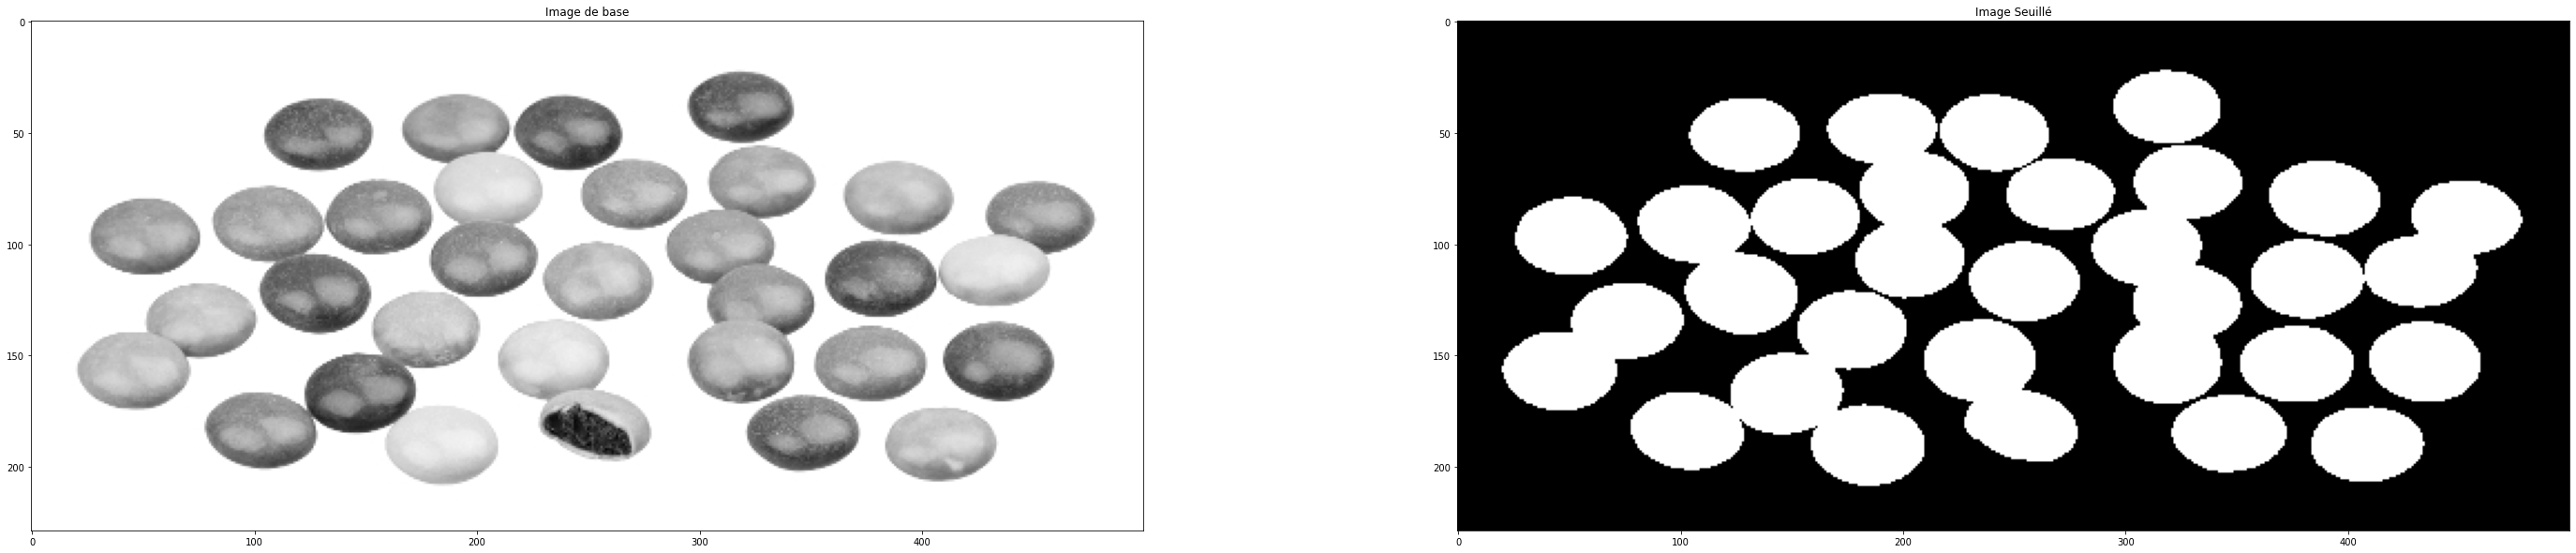

In [78]:
image = cv2.imread('smarties.png',0)
imageS = cv2.threshold(image,250,255,cv2.THRESH_BINARY_INV)
imageSS = imageS[1]

plt.figure(figsize=(50,10))

plt.subplot(121)
plt.title("Image de base")
plt.imshow(image,'gray') # affichage de l'image I en niveau de gris

plt.subplot(122)
plt.title("Image Seuillé")
plt.imshow(imageS[1],'gray') # affichage de l'image I en niveau de gris
plt.show() # déclenche l'affichage

Création des marqueurs :

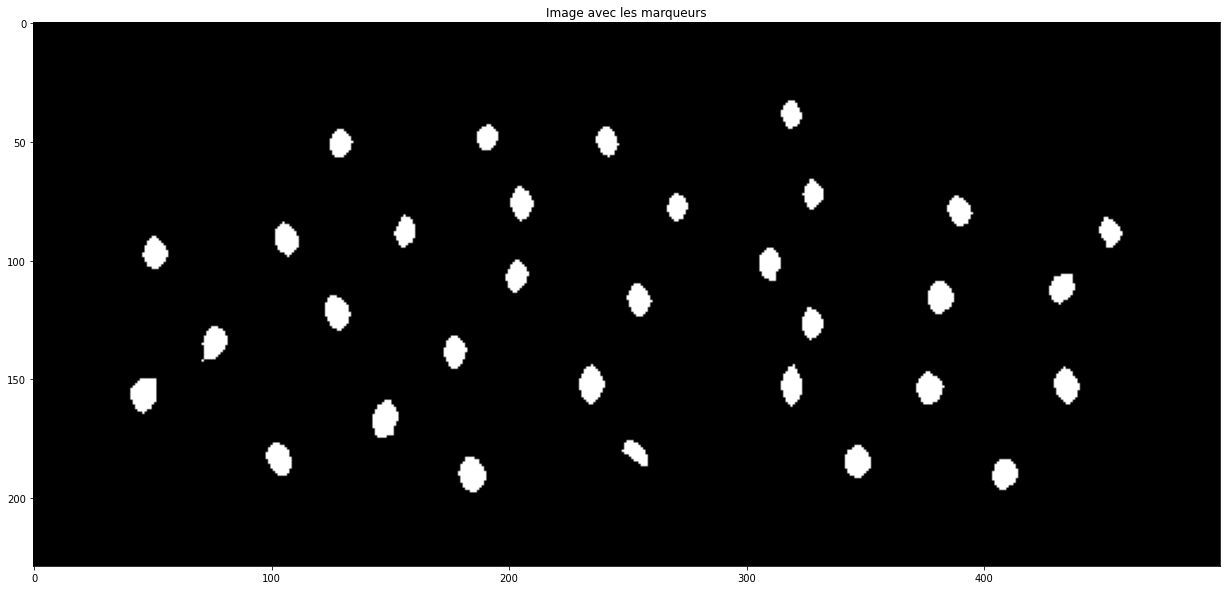

In [ ]:
S = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(40,20))
imageM = cv2.erode(imageSS, S, iterations = 1)

plt.figure(figsize=(50,10))

plt.subplot(121)
plt.title("Image avec les marqueurs")
plt.imshow(imageM,'gray') # affichage de l'image I en niveau de gris

Labellisation de mes marqueurs + du fond

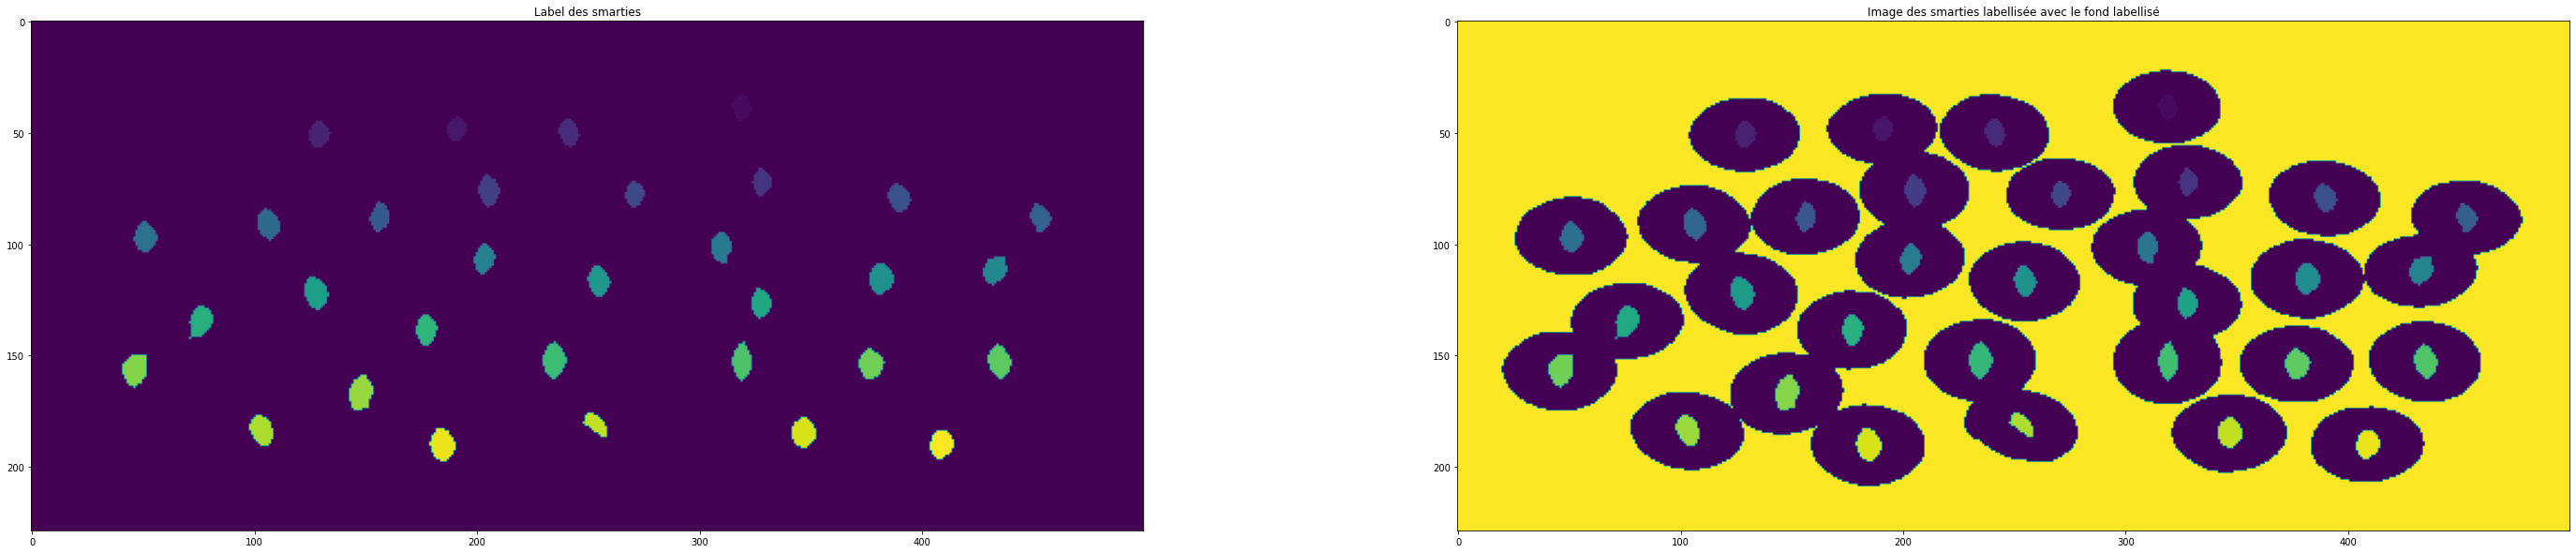

In [ ]:
imageML = cv2.connectedComponents(imageM)
imageMLL = imageML[1]

imageF = cv2.threshold(image,250,33,cv2.THRESH_BINARY)
imageFond = imageF[1]

imageMarqueurs = imageFond+imageMLL

plt.figure(figsize=(50,10))

plt.subplot(121)
plt.title("Label des smarties")
plt.imshow(imageML[1]) # affichage de l'image I en niveau de gris

plt.subplot(122)
plt.title("Image des smarties labellisée avec le fond labellisé")
plt.imshow(imageMarqueurs) # affichage de l'image I en niveau de gris
plt.show() # déclenche l'affichage

Création de la carte des distances

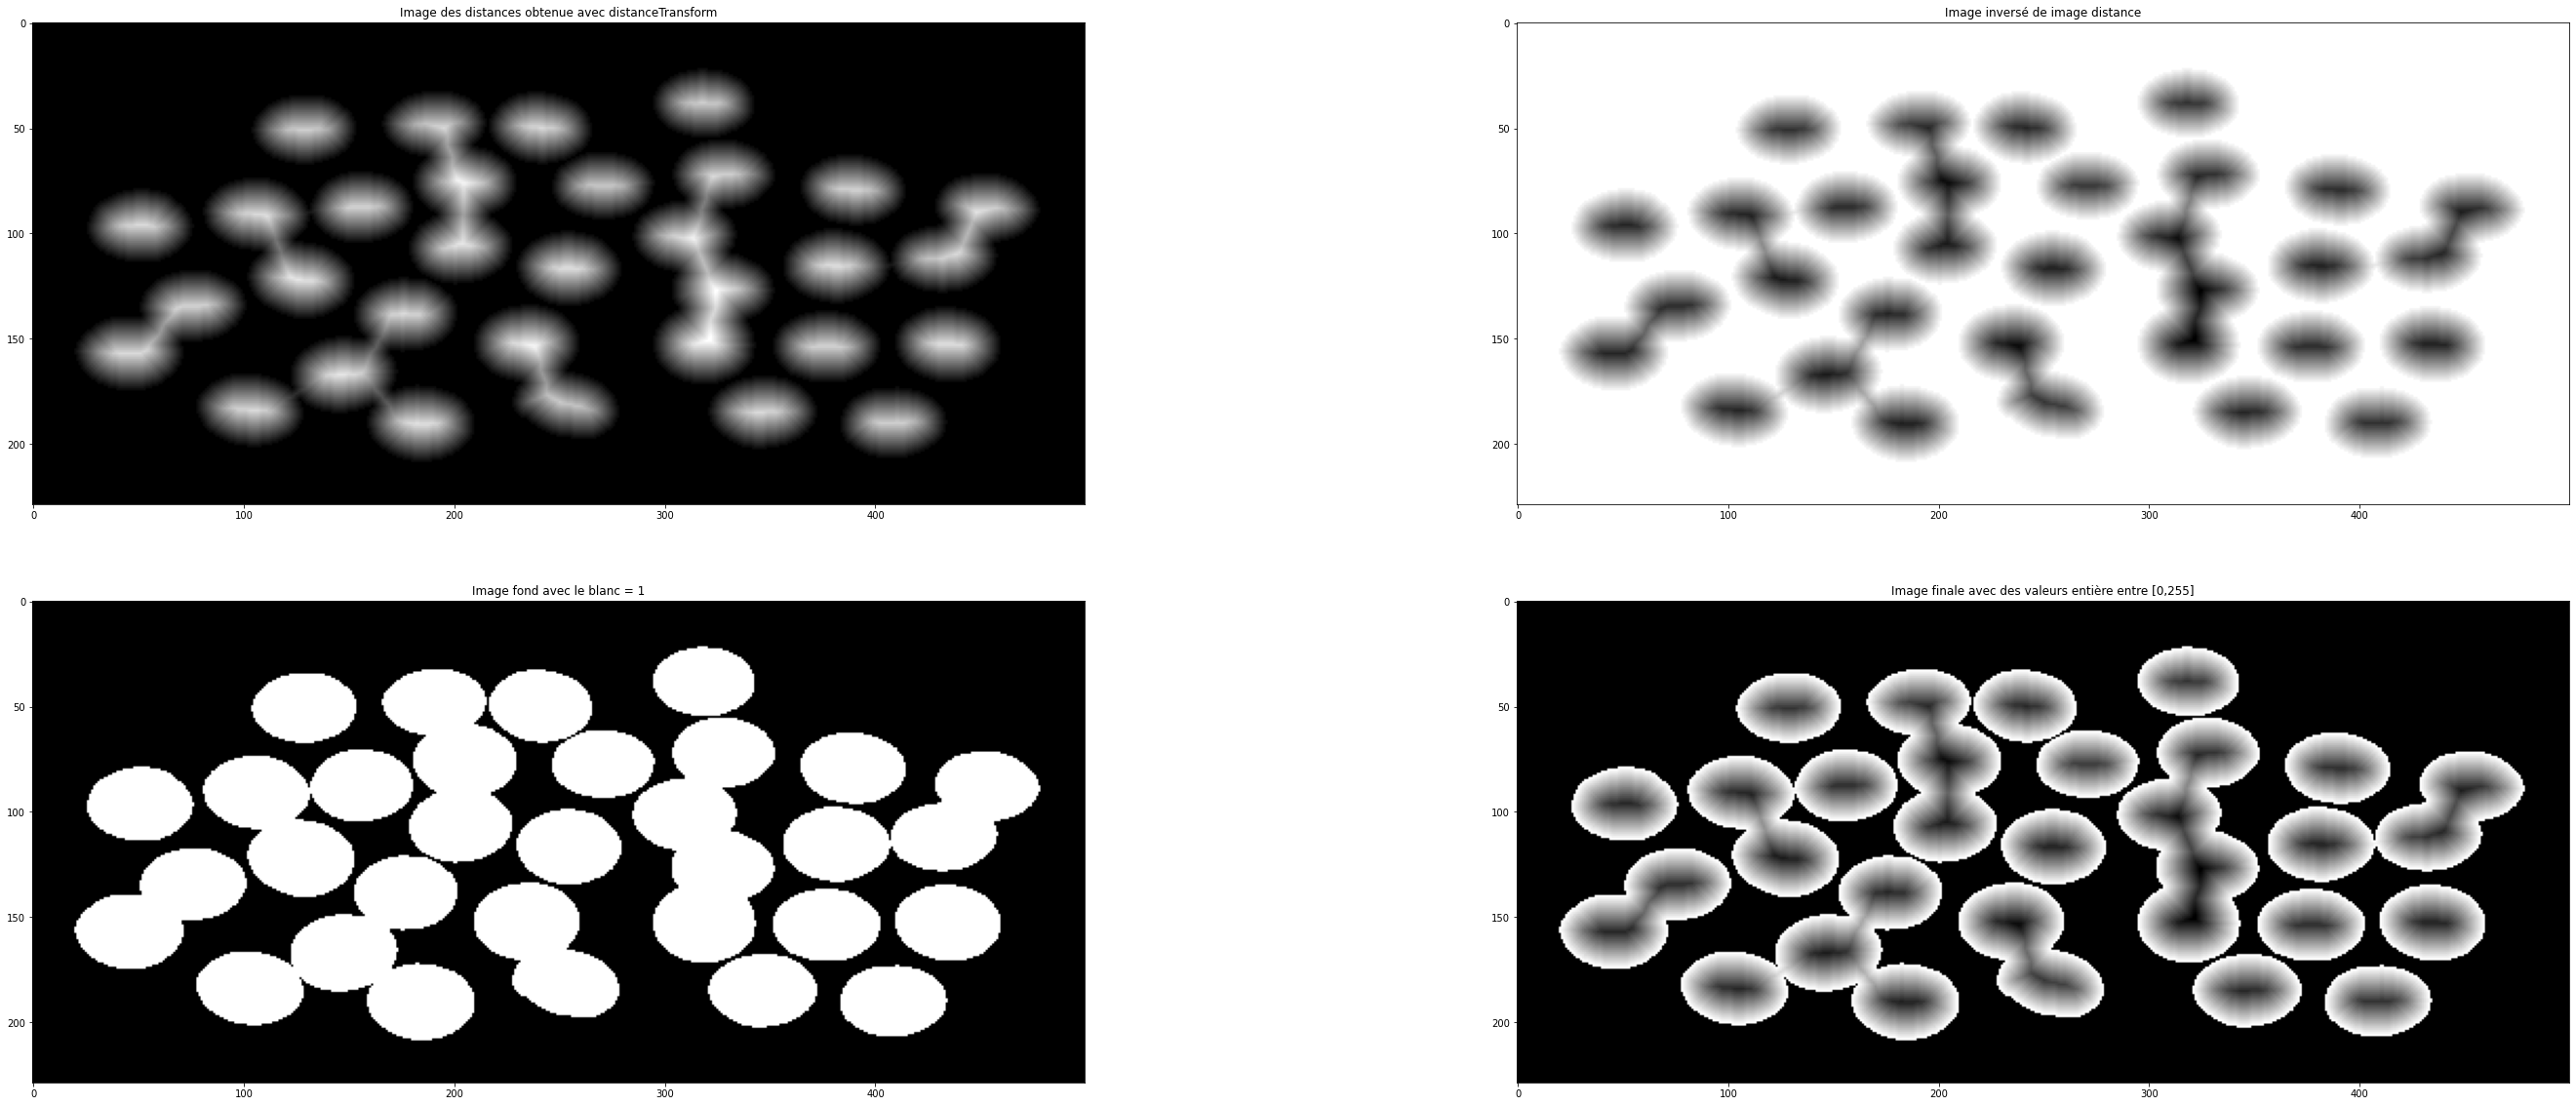

In [ ]:
imageD = cv2.distanceTransform(imageSS,cv2.DIST_L2,3,cv2.CV_32F)
u = np.max(imageD)
imageN = imageD * (255/u)

imageI = 255 - imageN

imageF = cv2.threshold(image,250,1,cv2.THRESH_BINARY_INV)
ImageFin = imageI * imageF[1]

u = np.max(ImageFin)
Imagetempo = ImageFin * (255/u)

imageDistFin = np.uint8(Imagetempo)
max2 = np.max(imageDistFin)
min2 = np.min(imageDistFin)



plt.figure(figsize=(50,20))

plt.subplot(221)
plt.title("Image des distances obtenue avec distanceTransform")
plt.imshow(imageD,'gray') # affichage de l'image I en niveau de gris

plt.subplot(222)
plt.title("Image inversé de image distance")
plt.imshow(imageI,'gray') # affichage de l'image I en niveau de gris

plt.subplot(223)
plt.title("Image fond avec le blanc = 1")
plt.imshow(imageF[1],'gray') # affichage de l'image I en niveau de gris

plt.subplot(224)
plt.title("Image finale avec des valeurs entière entre [0,255]")
plt.imshow(imageDistFin,'gray') # affichage de l'image I en niveau de gris
plt.show() # déclenche l'affichage


LPE :

In [79]:
T = imageMarqueurs

filex = [[]]*256
filey = [[]]*256

taille = imageMarqueurs.shape
taillex = taille[0]
tailley = taille[1]

for i in range(taillex):
    for j in range(tailley):
        if imageMarqueurs[i][j]!=0 :
            filex[imageDistFin[i][j]].append(i)
            filey[imageDistFin[i][j]].append(j)

# min = 0
# while min!=256 :
#     print(min)
#     if filex[min] != [] :
#         print("test")
#         while  filex[min]:
#             i = filex[min].pop(0)
#             j = filey[min].pop(0)

#             if(i<taillex-1):
#                 if T[i+1][j]==0:
#                     T[i+1][j]=T[i][j]
#                     u = imageDistFin[i+1][j]
#                     filex[np.max(u,min)].append(i+1)
#                     filey[np.max(u,min)].append(j)
                
#             if(j<tailley-1):
#                 if T[i][j+1]==0:
#                     T[i][j+1]=T[i][j]
#                     u = imageDistFin[i][j+1]
#                     filex[np.max(u,min)].append(i)
#                     filey[np.max(u,min)].append(j+1)

#             if(i!=0) :
#                 if T[i-1][j]==0:
#                     T[i-1][j]=T[i][j]
#                     u = imageDistFin[i-1][j]
#                     filex[np.max(u,min)].append(i-1)
#                     filey[np.max(u,min)].append(j)

#             if(j!=0):
#                 if T[i][j-1]==0:
#                     T[i][j-1]=T[i][j]
#                     u = imageDistFin[i][j-1]
#                     filex[np.max(u,min)].append(i)
#                     filey[np.max(u,min)].append(j-1)
#     else :
#         min+=1
#         #plt.imshow(T)
#         #plt.savefig("test_{}.png".format(min))

# plt.figure(2, figsize=(50,20))

# plt.subplot(121)
# plt.title("Image des distances obtenue avec distanceTransform")
# plt.imshow(imageMarqueurs) # affichage de l'image I en niveau de gris

# plt.subplot(122)
# plt.title("Image des distances obtenue avec distanceTransform")
# plt.imshow(T) # affichage de l'image I en niveau de gris
# plt.show()